## 1. Setup models

In [ ]:
# !git clone https://github.com/HemaxiN/DL_ECG_Classification.git

Cloning into 'DL_ECG_Classification'...
remote: Enumerating objects: 811, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 811 (delta 162), reused 204 (delta 127), pack-reused 552 (from 1)
Receiving objects: 100% (811/811), 14.00 MiB | 16.55 MiB/s, done.
Resolving deltas: 100% (501/501), done.


In [2]:
!pip install -U -r DL_ECG_Classification/requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached argon2_cffi-21.3.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached argon2_cffi_bindings-21.2.0-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached asttokens-2.0.5-py2.py3-none-any.whl.metadata (4.6 kB)
  Using cached attrs-21.4.0-py2.py3-none-any.whl.metadata (9.8 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl.metadata (11 kB)
  Using cached debugpy-1.6.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (1.1 kB)
  Using cached decorator-5.1.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached executing-0.8.3-py2.py3-none-any.whl.metadata (8.6 kB)
  Using cached fonttools-4.31.2-py3-none-any.whl.metadata (121 kB)
  Using cached importlib_resources-5.6.0-py3-none-any.whl.metadata (3.1 kB)
  Using cached ipykernel-6.

In [ ]:
!pip install -q tifffile pyts wfdb torchmetrics torchsummary


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


## 2. Setup PTB-XL dataset (v1.0.3)

In [1]:
!wget https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip

--2025-05-13 11:52:08--  https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1839504686 (1.7G) [application/zip]
Saving to: ‘ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip’

 ptb-xl-a-large-pub  92%[=================>  ]   1.59G   334KB/s    eta 6m 35s 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
!unzip ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip -d p

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wfdb
import ast
import pickle
import os


def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = 'ptb-xl-1.0.3/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)

def aggregate_diagnostic(y_dic, threshold=50):
    tmp = []
    for key, val in y_dic.items():
        if key in agg_df.index and val>=threshold:
            if key in ['CLBBB', 'ILBBB']:
                label = 'LBBB'
            elif key in ['CRBBB', 'IRBBB']:
                label = 'RBBB'
            elif key == '1AVB':
                label = '1dAVB'
            else:
                label = key
            if label in ['AFIB', 'AFLT', '1dAVB', 'RBBB', 'LBBB', 'NORM']:
                tmp.append(label)
    return list(set(tmp))

# Apply diagnostic superclass
Y['subclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y = Y[Y.subclass.apply(lambda x: len(x) > 0)]

# Split data into train and test (https://physionet.org/content/ptb-xl/1.0.1/)
test_fold = 10
dev_fold = 9

X_train = X[np.where((Y.strat_fold != test_fold) & (Y.strat_fold != dev_fold))]
y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != dev_fold)].subclass
print(f'Train records: {len(y_train)}')

X_dev = X[np.where(Y.strat_fold == dev_fold)]
y_dev = Y[(Y.strat_fold == dev_fold)].subclass
print(f'Val records: {len(y_dev)}')

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].subclass
print(f'Test records: {len(y_test)}')

Train records: 9672
Val records: 1210
Test records: 1226


In [40]:
# Flatten lists
y_train_flat = pd.Series([', '.join(sublist) for sublist in y_train])
y_dev_flat = pd.Series([', '.join(sublist) for sublist in y_dev])
y_test_flat = pd.Series([', '.join(sublist) for sublist in y_test])

# Get value counts
train_counts = y_train_flat.value_counts()
dev_counts = y_dev_flat.value_counts()
test_counts = y_test_flat.value_counts()

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'y_train': train_counts,
    'y_dev': dev_counts,
    'y_test': test_counts
})

summary_df = summary_df.fillna(0)
summary_df

,y_train,y_dev,y_test
1dAVB,428,57.0,55.0
AFIB,37,3.0,8.0
AFLT,47,5.0,4.0
LBBB,405,50.0,54.0
"LBBB, 1dAVB",83,11.0,8.0
NORM,7320,914.0,929.0
"NORM, 1dAVB",30,4.0,2.0
RBBB,1039,134.0,129.0
"RBBB, 1dAVB",90,8.0,14.0
"RBBB, LBBB",1,0.0,0.0


In [41]:
preprocessed_dir = 'Processed'
os.makedirs(preprocessed_dir, exist_ok=True)

pickle_out = open(os.path.join(preprocessed_dir, "X.pickle"),"wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y.pickle"),"wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_train.pickle"),"wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_train.pickle"),"wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_dev.pickle"),"wb")
pickle.dump(X_dev, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_dev.pickle"),"wb")
pickle.dump(y_dev, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_test.pickle"),"wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_test.pickle"),"wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

In [ ]:
def labelstovector(X,y):
  '''
  Convert the labels in y into vectors:
  Multi-label problem:
  NORM: [0,0,0,0,0]
  AFIB: [1,0,0,0,0]
  AFLT: [0,1,0,0,0]
  1dAVb: [0,0,1,0,0]
  RBBB: [0,0,0,1,0]
  LBBB: [0,0,0,0,1]
  Combination example:
  AFLT and LBBB: [0,1,0,0,1]
  LBBB and RBBB and 1dAVB: [0,0,1,1,1]
  -----------------------------------------------------------
  Args: X (number of examples, signal length, number of leads)
        y (number of examples, )
  '''
  y_list = []
  X_list = []
  for label, ecg in zip(y,X):
    if len(label)!=0: #ignore examples with label = []
      aux_vec = np.zeros(4)
      if 'AFLT' in label:
        aux_vec[0] = 1
      if '1dAVB' in label:
        aux_vec[1] = 1
      if 'RBBB' in label:
        aux_vec[2] = 1
      if 'LBBB' in label:
        aux_vec[3] = 1

      y_list.append(aux_vec)
      X_list.append(ecg)	

  return X_list, y_list

In [37]:
X_train_processed, y_train_processed = labelstovector(X_train, y_train)
X_dev_processed, y_dev_processed = labelstovector(X_dev, y_dev)
X_test_processed, y_test_processed = labelstovector(X_test, y_test)

pickle_out = open(os.path.join(preprocessed_dir, "X_train_processed.pickle"),"wb")
pickle.dump(X_train_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_train_processed.pickle"),"wb")
pickle.dump(y_train_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_dev_processed.pickle"),"wb")
pickle.dump(X_dev_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_dev_processed.pickle"),"wb")
pickle.dump(y_dev_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "X_test_processed.pickle"),"wb")
pickle.dump(X_test_processed, pickle_out)
pickle_out.close()

pickle_out = open(os.path.join(preprocessed_dir, "y_test_processed.pickle"),"wb")
pickle.dump(y_test_processed, pickle_out)
pickle_out.close()

print('Train size:', X_train.shape)
print('Val size:', X_dev.shape)
print('Test size:', X_test.shape)

(2844, 1000, 12)
(357, 1000, 12)
(362, 1000, 12)


In [50]:
# Prepare 2D dataset
%cd ..

!mkdir -p Images/dev/labels
!mkdir -p Images/dev/images
!mkdir -p Images/train/labels
!mkdir -p Images/train/images
!mkdir -p Images/test/labels
!mkdir -p Images/test/images

# Save processed dataset at
!mkdir -p Processed/model_specific/X_rnn_train
!mkdir -p Processed/model_specific/X_rnn_dev
!mkdir -p Processed/model_specific/X_rnn_test
!mkdir -p Processed/model_specific/X_cnn_train
!mkdir -p Processed/model_specific/X_cnn_dev
!mkdir -p Processed/model_specific/X_cnn_test
!mkdir -p Processed/model_specific/labels_train
!mkdir -p Processed/model_specific/labels_dev
!mkdir -p Processed/model_specific/labels_test

%cd DL_ECG_Classification

# Modify `create_dataset.py` appropriately to
# specify dataset path and save directory path
!python Dataset/create_dataset.py

Model output (4,)
[1. 0. 0. 0.]

1D input: (1000, 3)
[[-0.98395012 -0.564272   -0.11927116]
 [-1.30440752 -0.71998555 -0.17745295]
 [-0.88465273 -0.38175823 -0.12528143]
 ...
 [-0.70504968 -1.0881102  -0.7411463 ]
 [-0.51278768 -0.95451795 -0.6470171 ]
 [-0.922783   -1.23902242 -0.15312292]]

2D input: (256, 256)


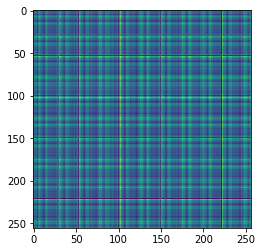

In [101]:
# View label
label = np.load('../Processed/model_specific/labels_dev/0.npy')
print('Model output', label.shape)
print(label)

# View RNN input
rnn_input = np.load('../Processed/model_specific/X_rnn_dev/0.npy')
print('\n1D input:', rnn_input.shape)
print(rnn_input)

# View CNN input
img = plt.imread('../Processed/model_specific/X_cnn_dev/0.tif')
print('\n2D input:', img.shape)
plt.imshow(img)
plt.show()

## 3. Training
Update `DL_ECG_Classification/config.py` for specific models to ensure dataset length is correctly specified:
```python
# train, dev, test split
samples = [2844,357,362]
```

Matrix printed at the end contains the column: TP, FN, FP, TN

In [80]:
%cd DL_ECG_Classification

/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification


In [ ]:
# 1D models
## RNN
!python3 rnn.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01
## LSTM
!python3 lstm.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01
## GRU
!python3 gru.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model '../saved_models/' -gpu_id 0 -learning_rate 0.01
!python3 gru_with_attention.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model '../saved_models/' -gpu_id 0 -learning_rate 0.01

/home/nepython/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
Loading data...
Training epoch 1
Training loss: 1.3938
Training epoch 2
Training loss: 1.2762
Training epoch 3
Training loss: 1.2358
Training epoch 4
Training loss: 1.2153
Training epoch 5
Training loss: 1.2038
Training epoch 6
Training loss: 1.1983
Training epoch 7
Training loss: 1.1921
Training epoch 8
Training loss: 1.1878
Training epoch 9
Training loss: 1.1833
Training epoch 10
Training loss: 1.1804
Training epoch 11
Training loss: 1.1782
Training epoch 12
Training loss: 1.1767
Training epoch 13
Training loss: 1.1752
Training epoch 14
Training loss: 1.1731
Training epoch 15
Training loss: 1.1715
Training epoch 1

In [ ]:
# 2D models
## AlexNet
!python3 alexnet.py -data '../Processed/model_specific/' -epochs 2 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01
## VGGNet
!python3 vggnet.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01
## ResNet
!python3 resnet.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01
## CNN
!python3 cnn.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01
!python cnn_gru.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01
!python cnn_lstm.py -data '../Processed/model_specific/' -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

/home/nepython/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
Loading data...
Training epoch 1
/home/nepython/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/nepython/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_S

In [ ]:
# Fusion models
!python early_fusion.py -signal_data '../Processed/model_specific/X_rnn' -image_data '../Processed/model_specific/X_cnn' -signal_model=bigru -image_model=resnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01
!python late_fusion.py -signal_data '../Processed/model_specific/X_rnn' -image_data '../Processed/model_specific/X_cnn' -signal_model=bigru -image_model=resnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01
!python joint_fusion.py -signal_data '../Processed/model_specific/X_rnn' -image_data '../Processed/model_specific/X_cnn' -signal_model=bigru -image_model=resnet -epochs 100 -batch_size 256 -path_save_model 'saved_models/' -gpu_id 0 -learning_rate 0.01

## Evaluation

In [ ]:
!python eval_saved_models.py -gpu_id 0 \
    -model gru \
    # -path ../saved_models/1748406645.414461model2 \
    -data ../Processed/model_specific/

/home/nepython/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/nepython/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/nepython/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/nepython/projects/COMP6011/Task3/DL_ECG_Classification/eval_saved_models.py:115: RuntimeWarning: invalid value encountered in scalar divide
  STTC_sensi = matrix[1,

array([1., 0., 0., 0.])